<a href="https://colab.research.google.com/github/naimurborno/Implementation-of-Vision-Transformer/blob/main/Vision Transformer for Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install -U tensorflow-addons

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 612.3/612.3 kB 4.7 MB/s eta 0:00:00


In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_addons as tfa
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [ ]:
num_classes = 6
input_shape = (200, 200, 3)

In [ ]:
learning_rate = 0.01
weight_decay = 0.0001
batch_size = 256
num_epochs =700
image_size = 72  # We'll resize input images to this size
patch_size = 16  # Size of the patches to be extract from the input images
num_patches = (image_size // patch_size) ** 2
projection_dim = 64
num_heads = 4
transformer_units = [
    projection_dim * 2,
    projection_dim,
]  # Size of the transformer layers
transformer_layers = 8
mlp_head_units = [2048, 1024]  # Size of the dense layers of the final classifier

In [ ]:
train_img_datagen=ImageDataGenerator(
)
test_img_datagen=ImageDataGenerator()

In [ ]:
train_data=train_img_datagen.flow_from_directory(
    '/content/drive/MyDrive/NEU Metal Surface Defects Data/test',
    target_size=(360, 360),
    batch_size=2306,
    class_mode='categorical',
    subset='training'
)
test_data=test_img_datagen.flow_from_directory(
    '/content/drive/MyDrive/NEU Metal Surface Defects Data/train',
    target_size=(200,200),
    class_mode='categorical',
    batch_size=72
)
#validation_data=test_img_datagen.flow_from_directory(
 #   '//kaggle/input/defects-class-and-location/images/images',
 #   target_size=(200,200),
 #   class_mode='categorical',
  #  batch_size=72,

#)

Found 72 images belonging to 6 classes.
Found 1728 images belonging to 6 classes.


In [ ]:
(X_train,y_train)=train_data.next()

In [ ]:
y_train_true=np.argmax(y_train,axis=1)

In [ ]:
data_augmentation = keras.Sequential(
    [
        layers.Normalization(),
        layers.Resizing(image_size, image_size),

    ],
    name="data_augmentation",
)
# Compute the mean and the variance of the training data for normalization.
data_augmentation.layers[0].adapt(X_train)

NameError: ignored

In [ ]:
def mlp(x, hidden_units, dropout_rate):
    for units in hidden_units:
        x = layers.Dense(units, activation=tf.nn.gelu)(x)
        x = layers.Dropout(dropout_rate)(x)
    return x

In [ ]:
class Patches(layers.Layer):
    def __init__(self, patch_size):
        super().__init__()
        self.patch_size = patch_size

    def call(self, images):
        batch_size = tf.shape(images)[0]
        patches = tf.image.extract_patches(
            images=images,
            sizes=[1, self.patch_size, self.patch_size, 1],
            strides=[1, self.patch_size, self.patch_size, 1],
            rates=[1, 1, 1, 1],
            padding="VALID",
        )
        patch_dims = patches.shape[-1]
        patches = tf.reshape(patches, [batch_size, -1, patch_dims])
        return patches

Image size: 72 X 72
Patch size: 16 X 16
Patches per image: 16
Elements per patch: 768


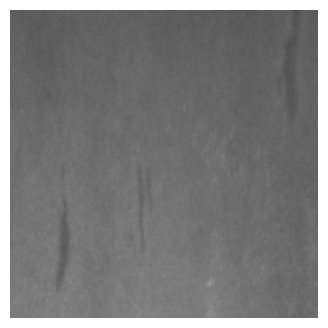

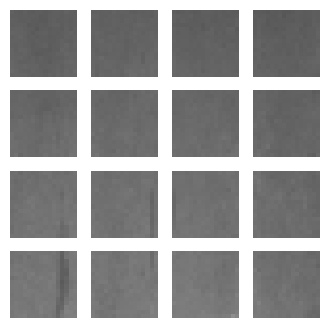

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(4, 4))
image = X_train[np.random.choice(range(X_train.shape[0]))]
image=image/255
plt.imshow(image)
plt.axis("off")

resized_image = tf.image.resize(
    tf.convert_to_tensor([image]), size=(image_size, image_size)
)
patches = Patches(patch_size)(resized_image)
print(f"Image size: {image_size} X {image_size}")
print(f"Patch size: {patch_size} X {patch_size}")
print(f"Patches per image: {patches.shape[1]}")
print(f"Elements per patch: {patches.shape[-1]}")

n = int(np.sqrt(patches.shape[1]))
plt.figure(figsize=(4, 4))
for i, patch in enumerate(patches[0]):
    ax = plt.subplot(n, n, i + 1)
    patch_img = tf.reshape(patch, (patch_size, patch_size, 3))
    plt.imshow(patch_img.numpy())
    plt.axis("off")

In [ ]:
class PatchEncoder(layers.Layer):
    def __init__(self, num_patches, projection_dim):
        super().__init__()
        self.num_patches = num_patches
        self.projection = layers.Dense(units=projection_dim)
        self.position_embedding = layers.Embedding(
            input_dim=num_patches, output_dim=projection_dim
        )

    def call(self, patch):
        positions = tf.range(start=0, limit=self.num_patches, delta=1)
        encoded = self.projection(patch) + self.position_embedding(positions)
        return encoded

In [ ]:
def create_vit_classifier():
    inputs = layers.Input(shape=input_shape)
    # Augment data.
    augmented = data_augmentation(inputs)
    # Create patches.
    patches = Patches(patch_size)(augmented)
    # Encode patches.
    encoded_patches = PatchEncoder(num_patches, projection_dim)(patches)

    # Create multiple layers of the Transformer block.
    for _ in range(transformer_layers):
        # Layer normalization 1.
        x1 = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
        # Create a multi-head attention layer.
        attention_output = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=projection_dim, dropout=0.1
        )(x1, x1)
        # Skip connection 1.
        x2 = layers.Add()([attention_output, encoded_patches])
        # Layer normalization 2.
        x3 = layers.LayerNormalization(epsilon=1e-6)(x2)
        # MLP.
        x3 = mlp(x3, hidden_units=transformer_units, dropout_rate=0.1)
        # Skip connection 2.
        encoded_patches = layers.Add()([x3, x2])

    # Create a [batch_size, projection_dim] tensor.
    representation = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
    representation = layers.Flatten()(representation)
    representation = layers.Dropout(0.5)(representation)
    # Add MLP.
    features = mlp(representation, hidden_units=mlp_head_units, dropout_rate=0.5)
    # Classify outputs.
    logits = layers.Dense(num_classes)(features)
    # Create the Keras model.
    model = keras.Model(inputs=inputs, outputs=logits)
    return model

In [ ]:
def sparse_categorical_accuracy(y_true, y_pred):
    # Ensure that the predictions are probabilities (apply softmax)
    y_pred = tf.nn.softmax(y_pred, axis=-1)
    # Get the predicted class index
    y_pred = tf.argmax(y_pred, axis=-1)
    # Cast y_true to float32 for data type compatibility
    y_true = tf.cast(y_true, dtype=tf.float32)
    # Calculate the accuracy
    accuracy = tf.reduce_mean(tf.cast(tf.equal(y_true, y_pred), dtype=tf.int64))
    return accuracy

In [ ]:
def run_experiment(model):
    optimizer = tfa.optimizers.AdamW(
        learning_rate=learning_rate, weight_decay=weight_decay
    )

    model.compile(
        optimizer=optimizer,
        loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=[
            keras.metrics.SparseCategoricalAccuracy(name="accuracy"),
            keras.metrics.SparseTopKCategoricalAccuracy(5, name="top-5-accuracy"),
        ],
    )

    checkpoint_filepath = "/tmp/checkpoint"
    checkpoint_callback = keras.callbacks.ModelCheckpoint(
        checkpoint_filepath,
        monitor="val_accuracy",
        save_best_only=True,
        save_weights_only=True,
    )

    history = model.fit(
        x=X_train,
        y=y_train_true,
        batch_size=batch_size,
        epochs=num_epochs,
        validation_split=0.3,
        callbacks=[checkpoint_callback],
    )

    model.load_weights(checkpoint_filepath)
    _, accuracy, top_5_accuracy = model.evaluate(X_test, y_test_true)
    print(f"Test accuracy: {round(accuracy * 100, 2)}%")
    print(f"Test top 5 accuracy: {round(top_5_accuracy * 100, 2)}%")

    return history


vit_classifier = create_vit_classifier()
history = run_experiment(vit_classifier)

Epoch 1/700
5/5 [==============================] - 14s 758ms/step - loss: 56.0089 - accuracy: 0.1844 - top-5-accuracy: 0.8561 - val_loss: 9.1171 - val_accuracy: 0.3738 - val_top-5-accuracy: 0.8516
Epoch 2/700
5/5 [==============================] - 1s 180ms/step - loss: 5.2958 - accuracy: 0.2457 - top-5-accuracy: 0.8627 - val_loss: 1.8604 - val_accuracy: 0.2601 - val_top-5-accuracy: 0.8671
Epoch 3/700
5/5 [==============================] - 1s 295ms/step - loss: 1.7640 - accuracy: 0.2763 - top-5-accuracy: 0.9065 - val_loss: 1.4360 - val_accuracy: 0.4740 - val_top-5-accuracy: 0.9769
Epoch 4/700
5/5 [==============================] - 1s 303ms/step - loss: 1.5766 - accuracy: 0.3706 - top-5-accuracy: 0.9396 - val_loss: 1.2865 - val_accuracy: 0.5453 - val_top-5-accuracy: 0.9769
Epoch 5/700
5/5 [==============================] - 1s 337ms/step - loss: 1.5004 - accuracy: 0.4061 - top-5-accuracy: 0.9520 - val_loss: 1.2110 - val_accuracy: 0.5549 - val_top-5-accuracy: 0.9846
Epoch 6/700
5/5 [======

ValueError: ignored

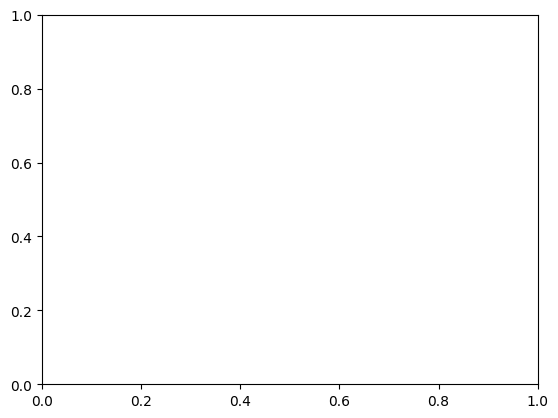

In [ ]:
#train and valid-acc
train_loss=history.history['loss']
train_acc=history.history['accuracy']
val_acc=history.history['val_accuracy']
epochs=np.arange(600)
plt.plot(epochs,train_acc)
plt.plot(epochs,val_acc)
plt.legend(['Training Accuracy','Validation Accuracy'])
plt.xlabel("Epochs")
plt.ylabel("Accuracy")


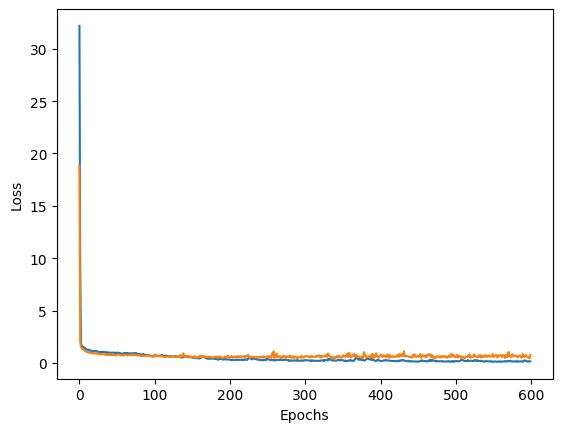

In [ ]:
#train and valid loss
train_loss=history.history['loss']
valid_loss=history.history['val_loss']
epochs=np.arange(600)
plt.plot(epochs,train_loss,label='Training Loss')
plt.plot(epochs,valid_loss,label='Validation Loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.show()

In [ ]:
import cv2

In [ ]:
image=cv2.imread('/content/drive/MyDrive/1808009/NEU Metal Surface Defects Data/test/Crazing/Cr_1.bmp')

In [ ]:
image.shape


(200, 200, 3)

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [ ]:
train_img_datagen=ImageDataGenerator(
)
test_img_datagen=ImageDataGenerator()

In [ ]:
train_data=train_img_datagen.flow_from_directory(
    '/content/drive/MyDrive/NEU Metal Surface Defects Data/train',
    target_size=(200,200),
    batch_size=1728,
    class_mode='categorical'
)
test_data=test_img_datagen.flow_from_directory(
    '/content/drive/MyDrive/NEU Metal Surface Defects Data/test',
    target_size=(200,200),
    class_mode='categorical',
    batch_size=72
)
validation_data=test_img_datagen.flow_from_directory(
    '/content/drive/MyDrive/1808009/NEU Metal Surface Defects Data/valid',
    target_size=(200,200),
    class_mode='categorical',
    batch_size=72
)

Found 1728 images belonging to 6 classes.
Found 72 images belonging to 6 classes.
Found 72 images belonging to 6 classes.


In [ ]:
(X_train,y_train)=train_data.next()

In [ ]:
X_train.shape

(1728, 200, 200, 3)

In [ ]:
y_train_true=np.argmax(y_train,axis=1)

In [ ]:
y_train_true.shape

(1728,)

In [ ]:
(X_test,y_test)=test_data.next()

In [ ]:
X_test.shape

(72, 200, 200, 3)

In [ ]:
y_test_true=np.argmax(y_test,axis=1)

In [ ]:
y_test_true.shape

(72,)

In [ ]:
image='/content/drive/MyDrive/NEU Metal Surface Defects Data/test/Crazing/Cr_1.bmp'

In [ ]:
image=cv2.imread(image)

NameError: ignored

In [ ]:
image=image/255

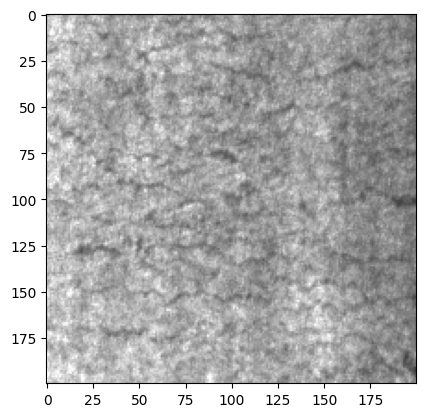

In [ ]:
plt.imshow(image)